In [1]:
%load_ext autoreload
%autoreload 2

# retina quality
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import G, c
from astropy import units as u
from scipy.stats import rv_histogram, skew
from scipy.stats import kurtosis as kurt_sp
from tqdm import tqdm

In [3]:
cd /Users/lambwg/Documents/Vanderbilt/Research/pop_synth/

/Users/lambwg/Documents/Vanderbilt/Research/pop_synth


In [4]:
from scripts import pop_synth

In [5]:
from cycler import cycler

rc_params = {#"backend": "pdf", 
             "axes.labelsize": 10, "lines.markersize": 4,
 "font.size": 10, "xtick.top": True, "ytick.right": True,
 "xtick.major.size": 6, "xtick.minor.size": 3, "ytick.major.size": 6,
 "ytick.minor.size": 3, "xtick.major.width": 0.5, "ytick.major.width": 0.5,
 "xtick.minor.width": 0.5, "ytick.minor.width": 0.5,
 "lines.markeredgewidth": 1, "axes.linewidth": 1.2, "legend.fontsize": 7,
 "xtick.labelsize": 10, "xtick.direction": "in", "xtick.minor.visible": True,
 "xtick.major.top": True, "xtick.minor.top": True, "ytick.labelsize": 10,
 "ytick.direction": "in", "ytick.minor.visible": True,
 "ytick.major.right": True, "ytick.minor.right": True, "savefig.dpi": 400,
 "path.simplify": True, "font.family": "serif", "font.serif": "Times",
 "text.usetex": True, "figure.figsize": [3.5503666805036667,
                                         2.1942472810764047],
 "axes.prop_cycle": cycler('color', ['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00'])}

plt.rcParams.update(rc_params)

In [6]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
H0 = cosmo.H0.to(u.km/u.s/u.km).value

# Figure 1

In [40]:
# load a population
h2cf = np.load('./data/accre_runs/h2cf_model3.npy',)

In [41]:
h2cf.shape

(10000000, 30)

In [42]:
Tspan = 20 * 365.24 * 86400
freqs = np.arange(1, 31)/Tspan

In [43]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
H0 = cosmo.H0.to(u.km/u.s/u.km).value

omega = (2*np.pi**2/(3*H0**2)) * freqs[np.newaxis, :]**2 * h2cf

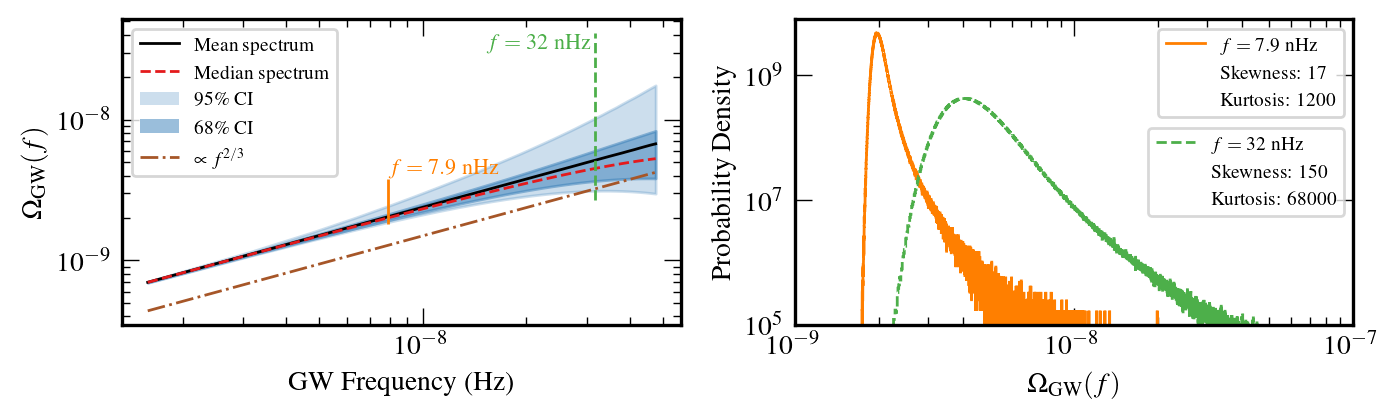

In [55]:
rc_params = {"text.usetex": True}
plt.rcParams.update(rc_params)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
fyr = 1/(365.24*86400)

# define axes
x = 3.5503666805036667
y = 2.1942472810764047
fig, (ax1, ax2) = plt.subplots(figsize=(2*x, y), ncols=2)

# plot contours of omega
p0_15, p2_5, p16, p50, p84, p97_5, p99_85 = np.percentile(omega,
                                                        [0.15, 2.5, 16, 50, 84, 97.5, 99.85],
                                            axis=0)
mean = np.mean(omega, axis=0)

ax1.plot(freqs, mean, color='k', lw=1, label='Mean spectrum')
ax1.plot(freqs, p50, color='C7', lw=1, ls='--', label='Median spectrum')
ax1.plot(freqs, ((2*np.pi**2/(3*H0**2)) * freqs**2 *
                 ((10**-14.8)*(freqs/fyr)**(-2/3))**2), lw=1, color='C4', ls='-.',
         label=r'$\propto f^{-2/3}$')
ax1.fill_between(freqs, p16, p84, color='C0', alpha=0.5)
ax1.fill_between(freqs, p2_5, p97_5, color='C0', alpha=0.25)

ax1.vlines(freqs[4], ymin=p0_15[4], ymax=p99_85[4],
            color='C1', lw=1)
ax1.text(freqs[4], p99_85[4], f'$f=7.9$ nHz', fontsize=8,
         va='bottom', ha='left', color='C1')
ax1.vlines(freqs[19], ymin=p0_15[19], ymax=p99_85[19],
            color='C2', lw=1, linestyle='--')
ax1.text(3e-8, p99_85[19], f'$f=32$ nHz', fontsize=8,
                va='top', ha='right', color='C2')

ax1.set_xlabel('GW Frequency (Hz)')
ax1.set_ylabel(r'$\Omega_\mathrm{GW}(f)$')  # change to energy density
ax1.set_xscale('log')
ax1.set_yscale('log')

# add legend
mean_line = Line2D([0], [0], color='k', lw=1, label='Mean spectrum')
median_line = Line2D([0], [0], color='C7', lw=1, linestyle='--',
                     label='Median spectrum')
p95 = Patch(facecolor='C0', alpha=0.25, label=f"95\% CI")
p68 = Patch(facecolor='C0', alpha=0.5, label=f"68\% CI")
prop_line = Line2D([0], [0], color='C4', lw=1, label='$\propto f^{2/3}$', ls='-.')
ax1.legend(handles=[mean_line, median_line, p95, p68, prop_line], loc='upper left')

# plot histograms of first and last frequencies
ax2.hist(omega[:, 4], bins='fd', histtype='step', color='C1', density=True,
         label=f'$f=7.9$ nHz')
ax2.hist(omega[:, 19], bins='fd', histtype='step', color='C2', density=True,
         label=f'$f=32$ nHz', linestyle='--')
ax2.set_xlabel(r'$\Omega_\mathrm{GW}(f)$')
ax2.set_ylabel('Probability Density')
ax2.set_xlim(1e-9, 1e-7)
ax2.set_ylim(1e5, 8e9)
ax2.set_xscale('log')
ax2.set_yscale('log')

skew_5 = skew(h2cf[:, 4])
skew_20 = skew(h2cf[:, 19])
kurt_5 = kurt_sp(h2cf[:, 4])
kurt_20 = kurt_sp(h2cf[:, 19])

f5 = Line2D([0], [0], color='C1', lw=1, label=f'$f=7.9$ nHz')
s5 = Line2D([0], [0], color='white', lw=1, label=f'Skewness: 17')
k5 = Line2D([0], [0], color='white', lw=1, label=f'Kurtosis: 1200')
f20 = Line2D([0], [0], color='C2', lw=1, linestyle='--',
             label=f'$f=32$ nHz')
s20 = Line2D([0], [0], color='white', lw=1, label=f'Skewness: 150')
k20 = Line2D([0], [0], color='white', lw=1, label=f'Kurtosis: 68000')

f5_legend = ax2.legend(handles=[f5, s5, k5], loc='upper right')
ax2.add_artist(f5_legend)
ax2.legend(handles=[f20, s20, k20], loc='center right', framealpha=0.75)

ax1.set_rasterized(True)
ax2.set_rasterized(True)

plt.tight_layout()
#plt.show();
plt.savefig('./notebooks/figures/omega_gw.pdf', dpi=300, bbox_inches='tight')

# Figure 2

In [53]:
def plot_grid(
    freqs: np.ndarray,
    log10_amp_min: float,
    log10_amp_max: float,
    ax: plt.Axes,
    map_func,
    map_func_kwargs: dict = None,
):
    """
    Plot a transformation of a regular grid.

    Parameters
    ----------
    freqs : np.ndarray
        The frequencies to plot.
    log10_amp_min : float
        The minimum log10 amplitude to plot.
    log10_amp_max : float
        The maximum log10 amplitude to plot.
    line_points : int
        The number of points to plot on each line.
    map_func : callable
        The mapping function to apply to the grid.
    map_func_kwargs : dict, optional
        Keyword arguments to pass to the mapping function.
    ax : matplotlib.axes.Axes
    """

    if map_func_kwargs is None:
        map_func_kwargs = {}

    # compute lines
    lines = map_func(freqs, 10**np.arange(log10_amp_min, log10_amp_max).astype(float),
                     **map_func_kwargs)

    # Plot all the lines.
    for ii, line in enumerate(lines):
        ax.loglog(freqs, line, lw=1, color='gray', alpha=0.2)

    return ax


# Define some mapping functions.
def powerlaw(freqs, amps, spec_idx=-11/3):
    fyr = 1/(365.24*86400)
    y = amps[:, np.newaxis] * (freqs[np.newaxis, :]/fyr) ** spec_idx
    return y

In [49]:
# load bootstrapped statistics - hc2f
boot_stats = np.load('./data/accre_runs/stats.npy')

In [50]:
boot_stats.shape

(4, 5, 30)

In [51]:
# convert stats to omega
boot_stats[0, :, :] = (2*np.pi**2/(3*H0**2)) * freqs[np.newaxis, :]**2 * boot_stats[0, :, :]
boot_stats[1, :, :] = ((2*np.pi**2/(3*H0**2)) * freqs[np.newaxis, :]**2)**2 * boot_stats[1, :, :]

In [57]:
"""
# loop over 5 models
stats = np.zeros((5, 4, 30))
for ii in range(5):
    h2cf = np.load(f'./data/accre_runs/h2cf_model{ii+1}.npy')
    omega = (2*np.pi**2/(3*H0**2)) * freqs[np.newaxis, :]**2 * h2cf

    # compute mean, variance, skewness, and kurtosis
    stats[ii, 0] = np.mean(omega, axis=0)
    stats[ii, 1] = np.var(omega, axis=0)
    stats[ii, 2] = skew(omega, axis=0)
    stats[ii, 3] = kurt_sp(omega, axis=0)

np.save('./mean_stats.npy', stats)
"""
stats = np.load('./mean_stats.npy')

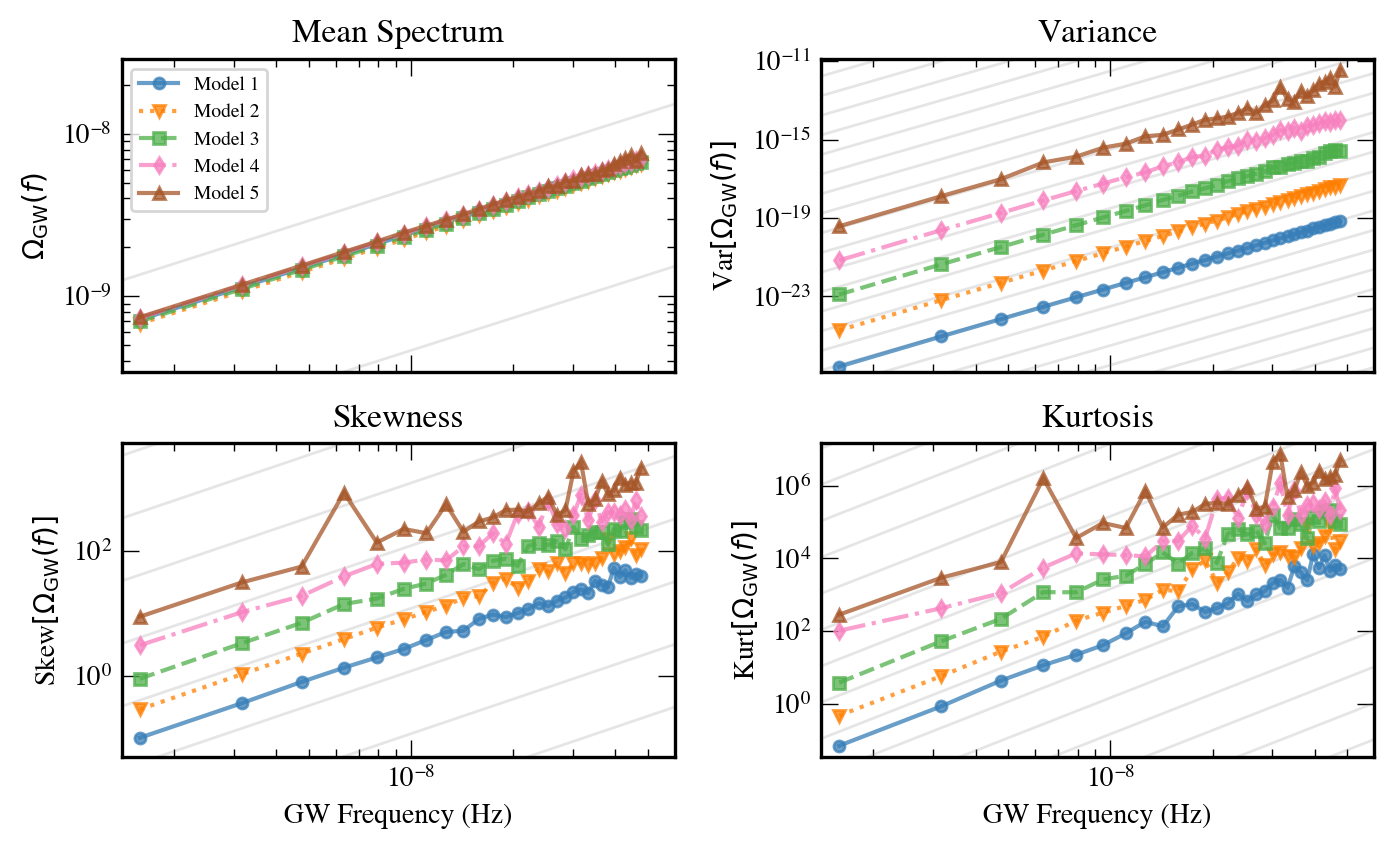

In [64]:
rc_params = {"text.usetex": True, "figure.figsize": [2*3.5503666805036667,
                                                      2.1942472810764047]}

x, y = [3.5503666805036667, 2.1942472810764047]
fig, ax = plt.subplots(figsize=(2*x, 2*y), ncols=2, nrows=2, sharex=True)

grid_points = np.linspace(1e-9, 6e-8, 100)
plot_grid(grid_points, -10, -7, ax[0, 0], powerlaw, {'spec_idx': 2/3})
plot_grid(grid_points, -30, 0, ax[0, 1], powerlaw, {'spec_idx': 5})
plot_grid(grid_points, -5, 15, ax[1, 0], powerlaw, {'spec_idx': 11/6})
plot_grid(grid_points, -5, 20, ax[1, 1], powerlaw, {'spec_idx': 11/3})

# find ylim for each plot
ylim = np.zeros((4, 2))

ms = ['o', 'v', 's', 'd', '^']
ls = ['-', ':', '--', '-.', '-']

# loop over 5 models
for ii in range(5):
    """
    h2cf = np.load(f'./data/accre_runs/h2cf_model{ii+1}.npy')
    omega = (2*np.pi**2/(3*H0**2)) * freqs[np.newaxis, :]**2 * h2cf

    # compute mean, variance, skewness, and kurtosis
    mean = np.mean(omega, axis=0)
    var = np.var(omega, axis=0)
    skewness = skew(omega, axis=0)
    kurtosis = kurt_sp(omega, axis=0)

    # estimate uncertainties
    n = 100000  #len(omega)
    boot_mean, boot_var, boot_skew, boot_kurt = [], [], [], []
    for jj in range(n):
        boot_ii = bootstrap(omega)
        boot_mean.append(np.mean(boot_ii, axis=0))
        boot_var.append(np.var(boot_ii, axis=0))
        boot_skew.append(skew(boot_ii, axis=0))
        boot_kurt.append(kurt_sp(boot_ii, axis=0))

    std_mean = np.std(boot_mean, axis=0)
    std_var = np.std(boot_var, axis=0)
    std_skew = np.std(boot_skew, axis=0)
    std_kurt = np.std(boot_kurt, axis=0)

    del boot_mean, boot_var, boot_skew, boot_kurt, boot_ii
    """
    # plot mean
    ax[0, 0].plot(freqs, stats[ii, 0], #yerr=boot_stats[0, ii],
                      color=f'C{ii}', ls=ls[ii],
                      label=f'Model {ii+1}', alpha=0.75, marker=ms[ii])

    # plot variance
    ax[0, 1].plot(freqs, stats[ii, 1], #yerr=boot_stats[1, ii],
                      color=f'C{ii}', ls=ls[ii],
                      label=f'Model {ii+1}', alpha=0.75, marker=ms[ii])

    # plot skewness
    ax[1, 0].plot(freqs, stats[ii, 2], #yerr=boot_stats[2, ii],
                      color=f'C{ii}', ls=ls[ii],
                      label=f'Model {ii+1}', alpha=0.75, marker=ms[ii])

    # plot kurtosis
    ax[1, 1].plot(freqs, stats[ii, 3], #yerr=boot_stats[3, ii],
                      color=f'C{ii}', ls=ls[ii],
                      label=f'Model {ii+1}', alpha=0.75, marker=ms[ii])
    
    # update ylim
    if ii == 0:
        ylim[0, 0] = np.min(stats[ii, 0])
        ylim[1, 0] = np.min(stats[ii, 1])
        ylim[2, 0] = np.min(stats[ii, 2])
        ylim[3, 0] = np.min(stats[ii, 3])
    else:
        ylim[0, 0] = min(ylim[0, 0], np.min(stats[ii, 0]))
        ylim[1, 0] = min(ylim[1, 0], np.min(stats[ii, 1]))
        ylim[2, 0] = min(ylim[2, 0], np.min(stats[ii, 2]))
        ylim[3, 0] = min(ylim[3, 0], np.min(stats[ii, 3]))
    
    ylim[0, 1] = max(ylim[0, 1], np.max(stats[ii, 0] + boot_stats[0, ii]))
    ylim[1, 1] = max(ylim[1, 1], np.max(stats[ii, 1] + boot_stats[1, ii]))
    ylim[2, 1] = max(ylim[2, 1], np.max(stats[ii, 2] + boot_stats[2, ii]))
    ylim[3, 1] = max(ylim[3, 1], np.max(stats[ii, 3] + boot_stats[3, ii]))

ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
#ax[0, 0].set_xlabel('GW Frequency (Hz)')
ax[0, 0].set_ylabel(r'$\Omega_\mathrm{GW}(f)$')
ax[0, 0].legend(loc='upper left')
ax[0, 0].set_title('Mean Spectrum')
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
#ax[0, 1].set_xlabel('GW Frequency (Hz)')
ax[0, 1].set_ylabel(r'Var$[\Omega_\mathrm{GW}(f)]$')
ax[0, 1].set_title('Variance')
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_xlabel('GW Frequency (Hz)')
ax[1, 0].set_ylabel(r'Skew$[\Omega_\mathrm{GW}(f)]$')
ax[1, 0].set_title('Skewness')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel('GW Frequency (Hz)')
ax[1, 1].set_ylabel(r'Kurt$[\Omega_\mathrm{GW}(f)]$')
ax[1, 1].set_title('Kurtosis')

for ii in range(2):
    for jj in range(2):
        ax[ii, jj].set_xlim(1.4e-9, 6e-8)
        ax[ii, jj].set_ylim(ylim[2*ii + jj, 0]/2, ylim[2*ii + jj, 1]*2)

plt.tight_layout()

# rasterize for smaller file size
ax[0, 0].set_rasterized(True)
ax[0, 1].set_rasterized(True)
ax[1, 0].set_rasterized(True)
ax[1, 1].set_rasterized(True)

#plt.show();
plt.savefig('./notebooks/figures/omega_gw_stats.pdf', dpi=300, bbox_inches='tight')

### checking model 5

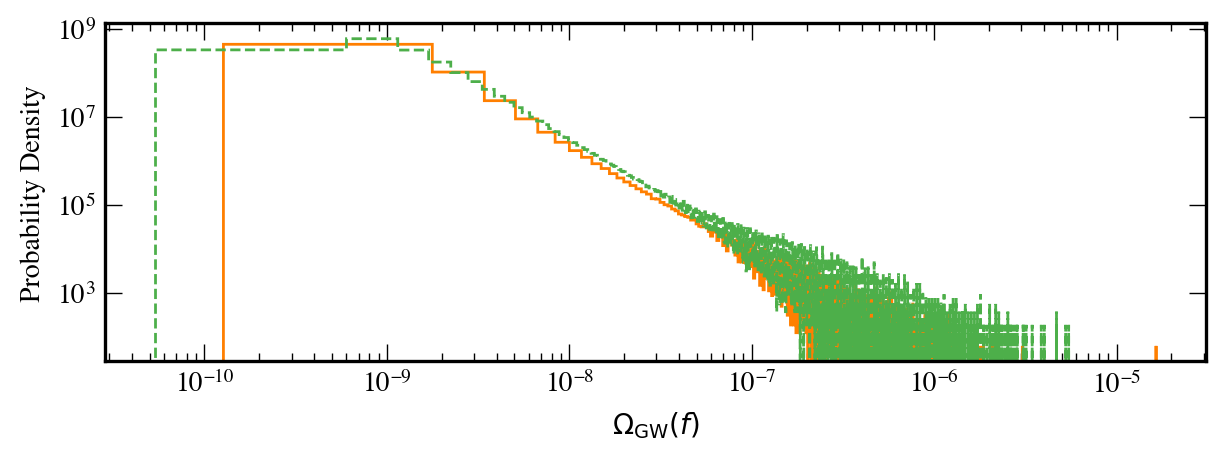

In [69]:
plt.hist(omega[:, 3], bins=10000, histtype='step', color='C1', density=True,
         label=f'$f=7.9$ nHz')
plt.hist(omega[:, 4], bins=10000, histtype='step', color='C2', density=True,
            label=f'$f=32$ nHz', linestyle='--')
plt.xlabel(r'$\Omega_\mathrm{GW}(f)$')
plt.ylabel('Probability Density')
#plt.xlim(1e-9, 1e-7)
#plt.ylim(1e5, 8e9)
plt.xscale('log')
plt.yscale('log')


In [73]:
omega[:, 1].max(), omega[:, 2].max(), omega[:, 3].max(), omega[:, 4].max(), omega[:, 5].max(), omega[:, 6].max()

(2.8599145889051573e-07,
 1.0563639993268346e-06,
 1.646971232892156e-05,
 5.464142732212551e-06,
 1.3012731646793604e-05,
 1.5466326781313442e-05)

In [75]:
data = omega[:, 3][omega[:, 3]!=omega[:, 3].max()]
skew(data), kurt_sp(data)

(84.55821640806018, 17032.502695784897)

In [76]:
skew(omega[:, 3]), kurt_sp(omega[:, 3])

(842.020813822112, 1613619.3663578616)

In [77]:
del omega, data

# Figure 3
How does changing characteristic mass change our plot?

In [7]:
# defining model
model3 = dict(alpha=0., log10_M_star=np.log10(1.8*10**8), beta=2, z0=1.8,
               n0_dot=1.5e-3)
model3a = dict(alpha=0., log10_M_star=7., beta=2, z0=1.8,
               n0_dot=1.875e-1)
model3b = dict(alpha=0., log10_M_star=9., beta=2, z0=1.8,
               n0_dot=8.6e-5)

# defining grid
Tspan = 20 * 365.24 * 86400
freqs = np.arange(1, 31)/Tspan
fbins = (np.arange(1, 32) - 0.5) / Tspan
f_mid = 0.5 * (fbins[1:] + fbins[:-1])

log10_M_bins = np.linspace(6, 11, 1001)
log10_M_mid = 0.5 * (log10_M_bins[1:] + log10_M_bins[:-1])

z_bins = np.linspace(0, 5, 101)
z_mid = 0.5 * (z_bins[1:] + z_bins[:-1])

N3 = pop_synth.smbhb_number_per_cell(fbins, 10**log10_M_bins, z_bins, model3,
                                     freq_lambda=-11/3)
N3a = pop_synth.smbhb_number_per_cell(fbins, 10**log10_M_bins, z_bins, model3a,
                                      freq_lambda=-11/3)
N3b = pop_synth.smbhb_number_per_cell(fbins, 10**log10_M_bins, z_bins, model3b,
                                      freq_lambda=-11/3)

#nreals = 10000
dlogf = (np.log(fbins[1:]) - np.log(fbins[:-1]))

#h2cf = pop_synth.pop_synth(N3, f_mid, log10_M_mid, z_mid, dlogf, nreals, 30)
#h2cf_a = pop_synth.pop_synth(N3a, f_mid, log10_M_mid, z_mid, dlogf, nreals, 30)
#h2cf_b = pop_synth.pop_synth(N3b, f_mid, log10_M_mid, z_mid, dlogf, nreals, 30)

In [8]:
h2cf = np.load(f'./data/accre_runs/h2cf_model3.npy')
h2cf_a = np.load(f'./data/accre_runs/h2cf_model3a.npy')
h2cf_b = np.load(f'./data/accre_runs/h2cf_model3b.npy')

In [9]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
H0 = cosmo.H0.to(u.km/u.s/u.km).value

omega = (2*np.pi**2/(3*H0**2)) * freqs[np.newaxis, :]**2 * h2cf
omega_a = (2*np.pi**2/(3*H0**2)) * freqs[np.newaxis, :]**2 * h2cf_a
omega_b = (2*np.pi**2/(3*H0**2)) * freqs[np.newaxis, :]**2 * h2cf_b

del h2cf, h2cf_a, h2cf_b

In [10]:
# compute ideal variance
mu, var, _, _ = pop_synth.ideal_gwb_stats(N3, f_mid, log10_M_mid, z_mid, dlogf)
mu_a, var_a, _, _ = pop_synth.ideal_gwb_stats(N3a, f_mid, log10_M_mid, z_mid, dlogf)
mu_b, var_b, _, _ = pop_synth.ideal_gwb_stats(N3b, f_mid, log10_M_mid, z_mid, dlogf)

# convert variance to omega
var = ((2*np.pi**2/(3*H0**2)) * freqs**2)**2 * var
var_a = ((2*np.pi**2/(3*H0**2)) * freqs**2)**2 * var_a
var_b = ((2*np.pi**2/(3*H0**2)) * freqs**2)**2 * var_b

In [11]:
np.sqrt(mu[19]), np.sqrt(mu_a[19]), np.sqrt(mu_b[19])

(2.0021473893403124e-15, 1.999728749452304e-15, 2.001379898769157e-15)

In [45]:
# bootstrap variance measurements
n = 100000  #len(omega)
boot_var, boot_var_a, boot_var_b = np.zeros((n, 30)), np.zeros((n, 30)), np.zeros((n, 30))

for jj in tqdm(range(n)):
    idx = pop_synth.bootstrap(n)
    boot_var[jj] = np.var(omega[idx], axis=0)
    boot_var_a[jj] = np.var(omega_a[idx], axis=0)
    boot_var_b[jj] = np.var(omega_b[idx], axis=0)

100%|██████████| 100000/100000 [2:45:12<00:00, 10.09it/s]    


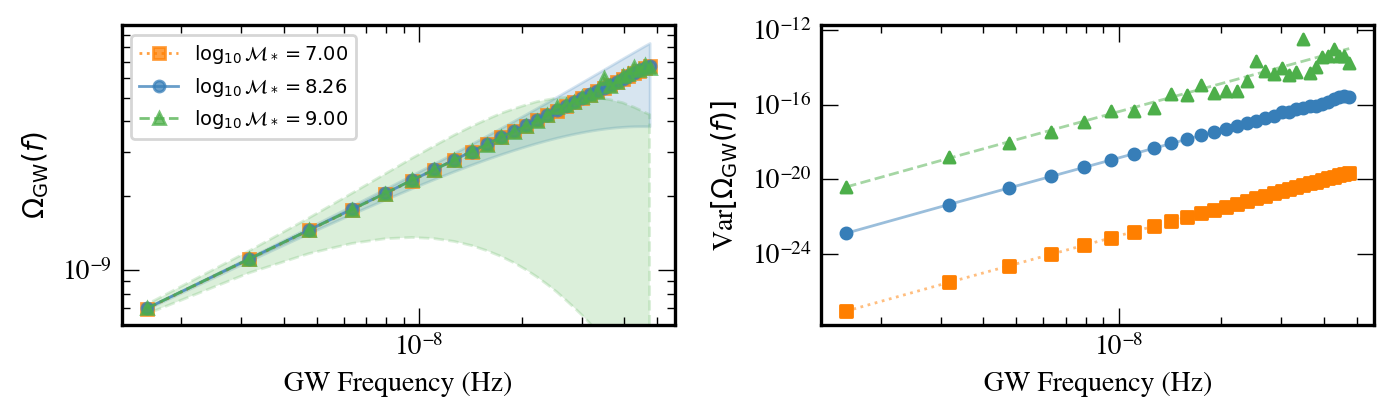

In [12]:
rc_params = {"text.usetex": False, "figure.figsize": [2*3.5503666805036667,
                                                      2.1942472810764047]}
plt.rcParams.update(rc_params)

fig, ax = plt.subplots(ncols=2)

ax[0].plot(freqs, np.mean(omega_a, axis=0), label=r'$\log_{10}\mathcal{M}_*=7.00$',
            color='C1', lw=1, ls=':', marker='s', alpha=0.75)
ax[0].plot(freqs, np.mean(omega, axis=0), label=r'$\log_{10}\mathcal{M}_*=8.26$',
           color='C0', lw=1, ls='-', marker='o', alpha=0.75)
ax[0].plot(freqs, np.mean(omega_b, axis=0), label=r'$\log_{10}\mathcal{M}_*=9.00$',
            color='C2', lw=1, ls='--', marker='^', alpha=0.75)

ax[0].fill_between(freqs, *np.percentile(omega_a, [16, 84], axis=0), alpha=0.2,
                   ls=':', color='C1')
ax[0].fill_between(freqs, *np.percentile(omega, [16, 84], axis=0), alpha=0.2,
                   ls='-', color='C0')
ax[0].fill_between(freqs, *np.percentile(omega_b, [16, 84], axis=0), alpha=0.2,
                   ls='--', color='C2')


#ax[1].errorbar(freqs, np.var(omega_a, axis=0), yerr=np.std(boot_var_a, axis=0), color='C1', fmt='s')
#ax[1].errorbar(freqs, np.var(omega, axis=0), yerr=np.std(boot_var, axis=0), color='C0', fmt='o')
#ax[1].errorbar(freqs, np.var(omega_b, axis=0), yerr=np.std(boot_var_b, axis=0), color='C2', fmt='^')
ax[1].scatter(freqs, np.var(omega_a, axis=0), color='C1', label=r'$\log_{10}\mathcal{M}_*=7.00$',
              marker='s')
ax[1].scatter(freqs, np.var(omega, axis=0), color='C0', label=r'$\log_{10}\mathcal{M}_*=8.26$',
              marker='o')
ax[1].scatter(freqs, np.var(omega_b, axis=0), color='C2', label=r'$\log_{10}\mathcal{M}_*=9.00$',
              marker='^')

ax[1].plot(freqs, var, color='C0', lw=1, ls='-', alpha=0.5)
ax[1].plot(freqs, var_a, color='C1', lw=1, ls=':', alpha=0.5)
ax[1].plot(freqs, var_b, color='C2', lw=1, ls='--', alpha=0.5)

ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('GW Frequency (Hz)')
ax[0].set_ylabel(r'$\Omega_\mathrm{GW}(f)$')
ax[0].set_ylim(6e-10)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('GW Frequency (Hz)')
ax[1].set_ylabel(r'Var$[\Omega_\mathrm{GW}(f)]$')

plt.tight_layout()
#plt.show();
plt.savefig('./notebooks/figures/omega_gw_char_mass.pdf',
            dpi=300, bbox_inches='tight')

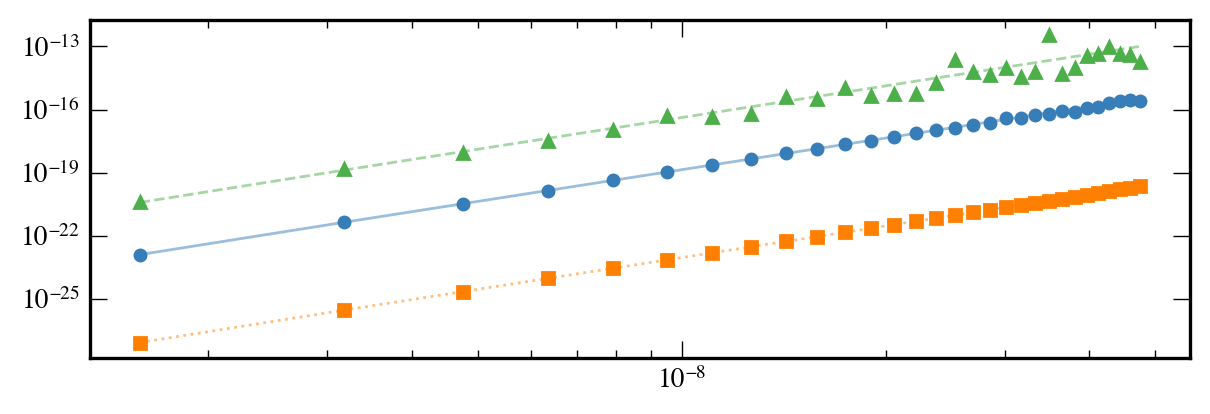

In [37]:
rc_params = {"text.usetex": False, "figure.figsize": [3.5503666805036667,
                                                      2.1942472810764047]}

plt.errorbar(freqs, np.var(omega, axis=0), yerr=0, color='C0', fmt='o')
plt.errorbar(freqs, np.var(omega_a, axis=0), yerr=0, color='C1', fmt='s')
plt.errorbar(freqs, np.var(omega_b, axis=0), yerr=0, color='C2', fmt='^')

plt.plot(freqs, var, color='C0', lw=1, ls='-', alpha=0.5)
plt.plot(freqs, var_a, color='C1', lw=1, ls=':', alpha=0.5)
plt.plot(freqs, var_b, color='C2', lw=1, ls='--', alpha=0.5)

plt.xscale('log')
plt.yscale('log')

# play with mass limit

In [144]:
model5 = dict(alpha=-1, log10_M_star=9., beta=1, z0=0.5, n0_dot=2e-6)
N3b_mass_lim = pop_synth.dN_dlog10Mdzdlogf(fbins, 10**log10_M_bins, z_bins, model3b,
                                             mass_limit=True, freq_lambda=-11/3)

In [145]:
mean, var, s3, k3 = pop_synth.ideal_gwb(N3b_mass_lim, f_mid, log10_M_mid, z_mid,
                                        dlogf, 30)

In [146]:
mean

array([2.28240557e-28, 8.77285397e-29, 4.83931451e-29, 3.07350493e-29,
       2.11137249e-29, 1.51459532e-29, 1.11990074e-29, 8.48183813e-30,
       6.56007219e-30, 5.11641980e-30, 4.06145575e-30, 3.24095598e-30,
       2.63030090e-30, 2.11423698e-30, 1.75139359e-30, 1.43482951e-30,
       1.19529240e-30, 9.98031553e-31, 8.34947709e-31, 7.10677483e-31,
       5.96556650e-31, 5.09507562e-31, 4.35824557e-31, 3.73305979e-31,
       3.25508331e-31, 2.79513932e-31, 2.44354391e-31, 2.10261906e-31,
       1.84212590e-31, 1.61554865e-31])

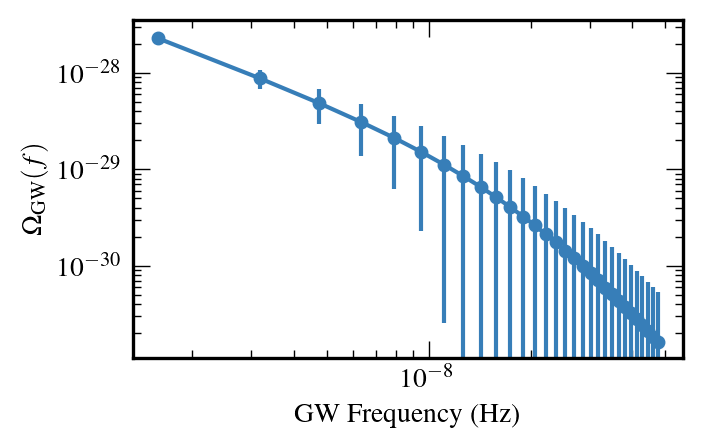

In [147]:
plt.errorbar(freqs, mean, yerr=np.sqrt(var), fmt='-o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GW Frequency (Hz)')
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$')
plt.show();

In [148]:
np.sqrt(mean[19])

8.43016893698263e-16

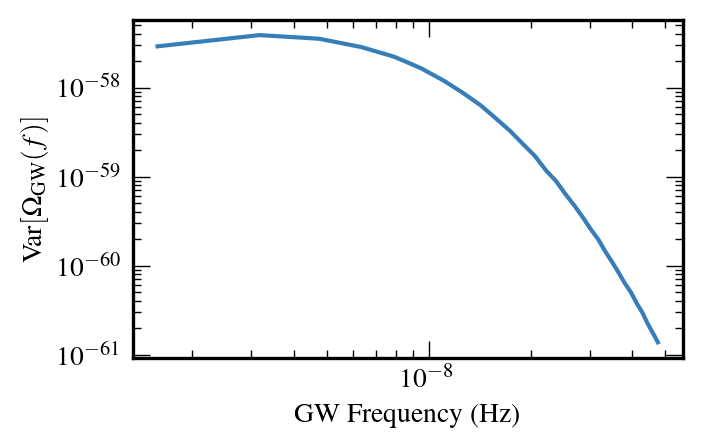

In [149]:
plt.plot(freqs, var)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GW Frequency (Hz)')
plt.ylabel(r'$\mathrm{Var}[\Omega_\mathrm{GW}(f)]$')
plt.show();